In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/cleaned.csv', index_col='id')

In [3]:
df = pd.read_csv('../data/cleaned.csv', index_col='id')

X = df[[col for col in df.columns if col != 'num']]
y = df['num'].astype(str)

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

#### RandomForestClassifier for feature selection

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [5]:
from sklearn.metrics import accuracy_score
pre = rf.predict(X_test)

print(f"Testing Accuracy: {accuracy_score(pre, y_test):.2f}")

Testing Accuracy: 0.64


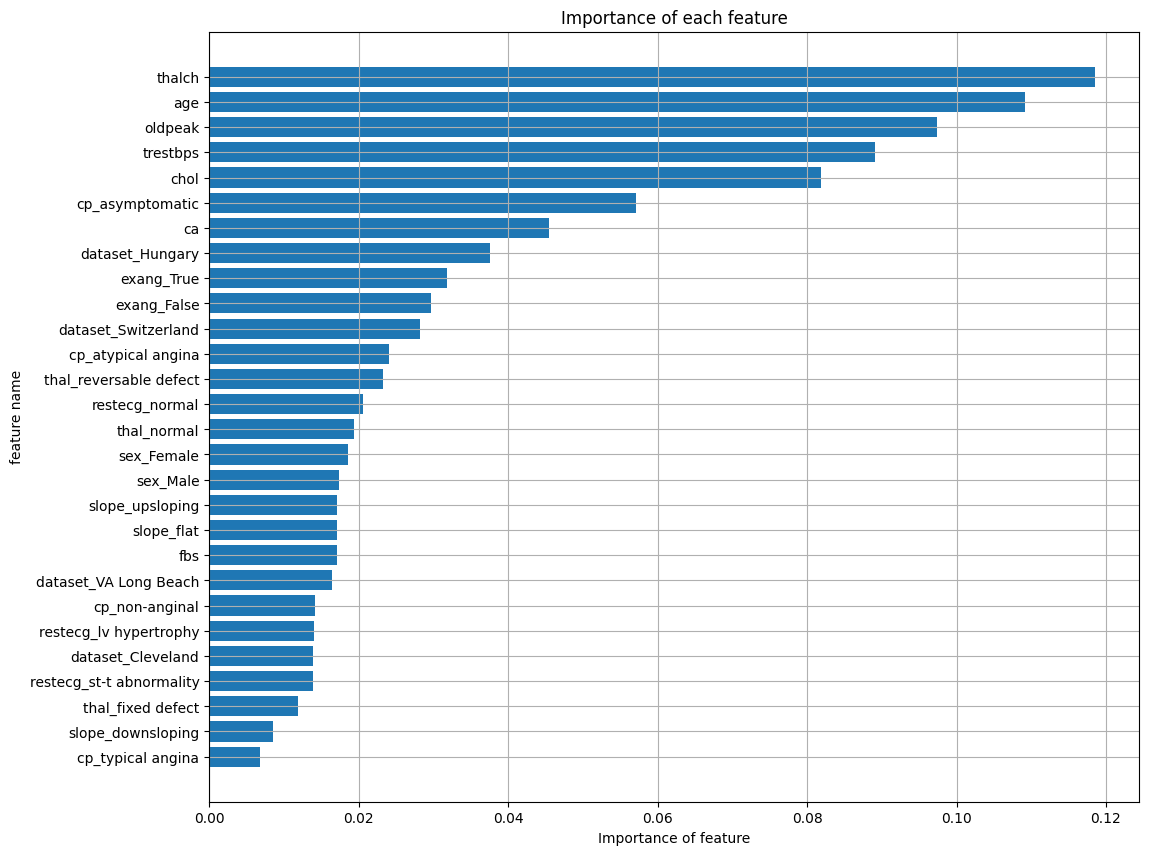

In [6]:
df2 = pd.DataFrame({
  'Feature': X.columns,
  'Importance': rf.feature_importances_
}).sort_values(by='Importance')

plt.figure(figsize=(12, 10))
plt.barh(width=df2['Importance'], y=df2['Feature'])
plt.grid(True)
plt.xlabel("Importance of feature")
plt.ylabel("feature name")
plt.title("Importance of each feature")
plt.show()

In [7]:
# elbow method to get the best number of features
arr = []
for i in range(1, df2['Feature'].size+1):
  selected = df2.iloc[-i:]['Feature'].unique()

  rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
  rf2.fit(X_train[selected], y_train)

  pre = rf2.predict(X_test[selected])

  arr.append([i, accuracy_score(pre, y_test)])

Text(0.5, 1.0, 'Best number of features')

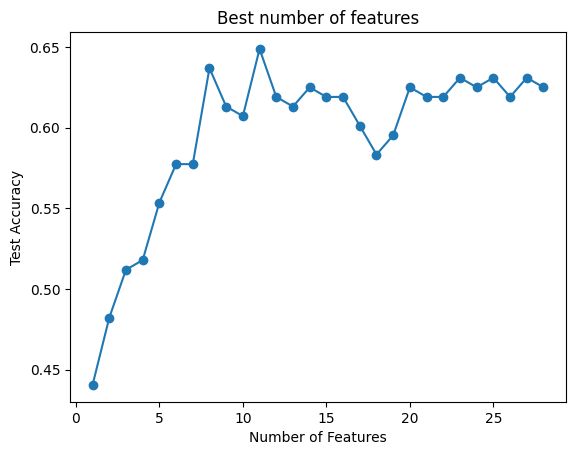

In [8]:
arr = np.array(arr)
plt.plot(arr[:,0], arr[:,1], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Test Accuracy")
plt.title("Best number of features")

After some hyperparamter tuning The results as follows:

top 3 Features: 0.51

top 5 Features: 0.55

top 8 Features: 0.64 (Best)

top 10 Features: 0.61

top 15 Features: 0.62

Final result: I resulted the same accuracy with 8 features rather than 28 feature

In [9]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE

# 8 as the best result
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100,random_state=42), n_features_to_select=8)
rfe.fit(X, y)

X = rfe.transform(X)

In [10]:
final = np.c_[X, y] # combine features with target variable

# Save as csv to use in another file
final = pd.DataFrame(final)
final.to_csv('../data/feature_selected.csv')

### Chi-Square Test

In [11]:
from scipy.stats import chisquare

chi2, p = chisquare(y.astype(float).values, y.astype(float))
p

1.0